In [1]:
import cvxpy as cvx
import numpy as np
import matplotlib.pyplot as plt

In [2]:
n = 4

# initialize vector for price changes pbar and covariance matrix Sigma 
pbar = np.array([.12, .1, .07, .03])
Sigma = np.array([[.0064, .0008, -.0011, .0],
       [.0008, .0025, .0, .0],
       [-.0011, .0, .0004, .0],
       [.0, .0, .0, .0]])

# Initialize quadratic objective function -pbar.T @ x + x.T @ Sigma @ x
x = cvx.Variable(shape=(n, 1))
mu_vals = np.logspace(start = 1, stop = 7, num = 100)
cp_quad_sigma = cvx.quad_form(x, Sigma)

runs = 100

returns = list()
std = list()

Text(0, 0.5, 'returns')

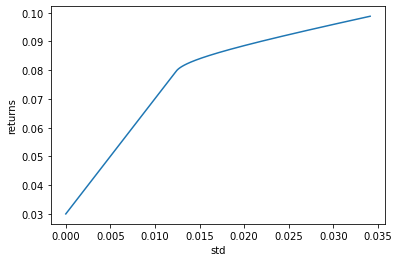

In [4]:
# Markowitz optimization approach by minimizing negative return and risk measure 

for i in range(runs):
    
    # generate different combinations of portfolios (std vs returns) varied by mu
    
    mu = mu_vals[i]
    
    obj_marko = -pbar.T @ x + mu * cvx.quad_form(x, Sigma)

    const = [cvx.sum(x) == 1]
    const += [x >= 0]

    obj_marko = cvx.Problem(cvx.Minimize(obj_marko), const).solve()
    
    returns.append(pbar.T @ x.value)
    std.append(np.sqrt((x.value).T @ Sigma @ x.value))
    
  
plt.plot(np.ndarray.flatten(np.array(std)), np.ndarray.flatten(np.array(returns)))
plt.xlabel('std')
plt.ylabel('returns')

Text(0, 0.5, 'returns')

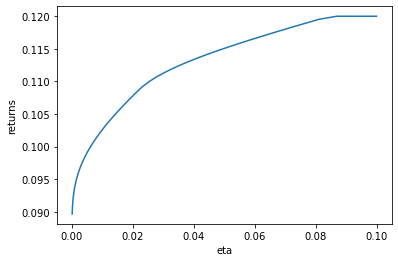

In [31]:
# portfolio optimization with loss constraint 

# solve:
# max pbar.T x s.t.
# constraint that probability for negative return is lower then beta -> calculate for beta
# Phi((beta - pbar.T x) / (sqrt(x.T Sigma x))) <= eta,
# sum(x) == 1 and x >= 0
# We can isolate beta by using Phi^-1 inverse mapping 

# load package for standard normal distribution 
from scipy.stats import norm
from numpy import linalg as la

y = cvx.Variable(shape=(n, 1))

# eta in log scale from 10-4 to 10-1
eta_vals = np.logspace(start = -4, stop = -1, num = 100)
beta = 0.01

#eigenvector decomposition of Sigma because cvxpy is not able to take sqrt of quadform sqrt(x.T Sigma x)
V, D = la.eigh(Sigma)

sqrtSigma = D @ np.sqrt(np.diag(V)) @ D.T

returns_set = [0] * 100

for i in range(runs):
    
    # generate different combinations of portfolios (std vs returns) varied by mu
    
    eta = eta_vals[i]
    
    # max return 
    
    obj_max_return = pbar.T @ y
    
    # reformulated constraints (isolated beta)
    
    const_1 = [cvx.sum(y) == 1]
    const_1 += [y >= 0]
    const_1 += [norm.ppf(eta) * cvx.norm(sqrtSigma @ y, 2) + pbar.T @ y >= beta]

    obj_return = cvx.Problem(cvx.Maximize(obj_max_return), const_1).solve()
    
    returns_set[i] = obj_return


plt.plot(eta_vals, np.array(returns_set))
plt.xlabel('eta')
plt.ylabel('returns')    